In [20]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [21]:
style.use('dark_background')
input_output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [22]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???

place_name = 'Rotterdam'
local_crs = 'EPSG:28992'
sub_folder = str(place_name).replace(' ', '')+'_14Apr2022'

betw_radius = 800

# Load data

In [23]:
value_col = '_Betweenness'
id_col = '__GUID'

In [24]:
place = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), 'place.geojson'))
place.crs = local_crs

# With detours

In [25]:
filename = 'betw_cld_{}_dr12.geojson'.format(str(betw_radius))
betw_cld = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), filename))
betw_cld = betw_cld[betw_cld.geometry.type == 'LineString']
betw_cld.crs = local_crs
betw_cld[value_col] = betw_cld[value_col].astype(float)
col_cld = 'betw_cld_{}_dr12'.format(str(betw_radius))
betw_cld[col_cld] = betw_cld[value_col]

In [26]:
filename = 'betw_adl_{}_dr12.geojson'.format(str(betw_radius))
betw_adl = gpd.read_file(os.path.join(os.path.join(input_output_folder, sub_folder), filename))
betw_adl = betw_adl[betw_adl.geometry.type == 'LineString']
betw_adl.crs = local_crs
betw_adl[value_col] = betw_adl[value_col].astype(float)
col_adl = 'betw_adl_{}_dr12'.format(str(betw_radius))
betw_adl[col_adl] = betw_adl[value_col]

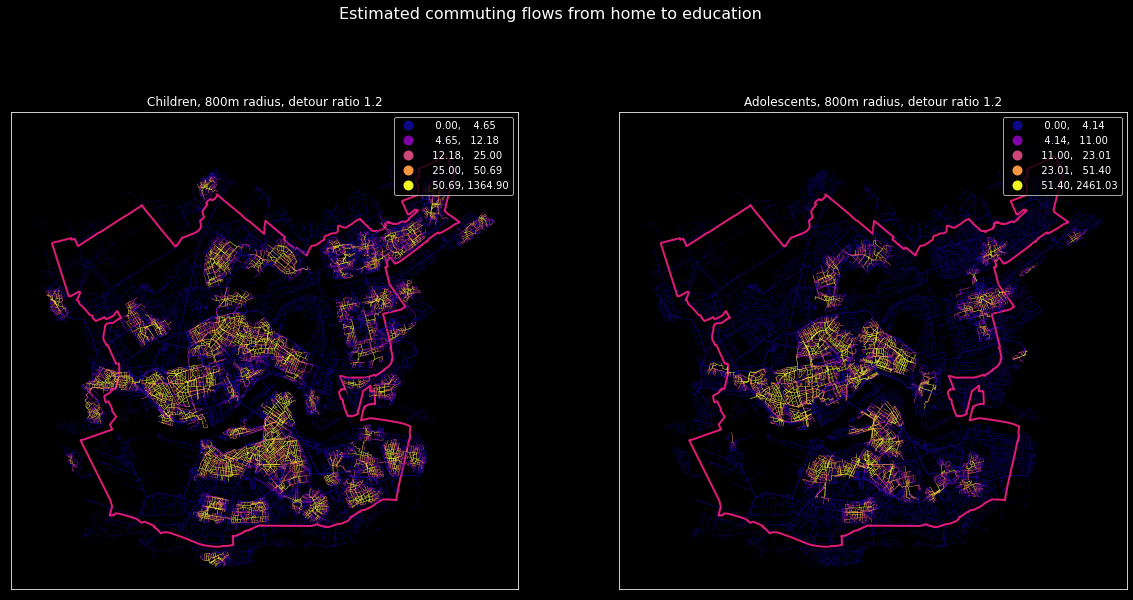

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
fig.suptitle('Estimated commuting flows from home to education', fontsize=16)

betw_cld.plot(ax=axs[0], color='#130689', zorder=1, linewidth=0.2)
betw_cld[betw_cld[col_cld]>0].plot(ax=axs[0], column=col_cld, cmap='plasma', scheme='quantiles', zorder=2, legend=True, linewidth=0.5)
place.plot(ax=axs[0], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
axs[0].set_title('Children, {}m radius, detour ratio 1.2'.format(str(betw_radius)))
             
betw_adl.plot(ax=axs[1], color='#130689', zorder=1, linewidth=0.2)
betw_adl[betw_adl[col_adl]>0].plot(ax=axs[1], column=col_adl, cmap='plasma', scheme='quantiles', zorder=2, legend=True, linewidth=0.5)
place.plot(ax=axs[1], facecolor='none', edgecolor='#dd1c77', linestyle='-', linewidth=2)
axs[1].set_title('Adolescents, {}m radius, detour ratio 1.2'.format(str(betw_radius)))


for ax in axs:
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

plt.show()

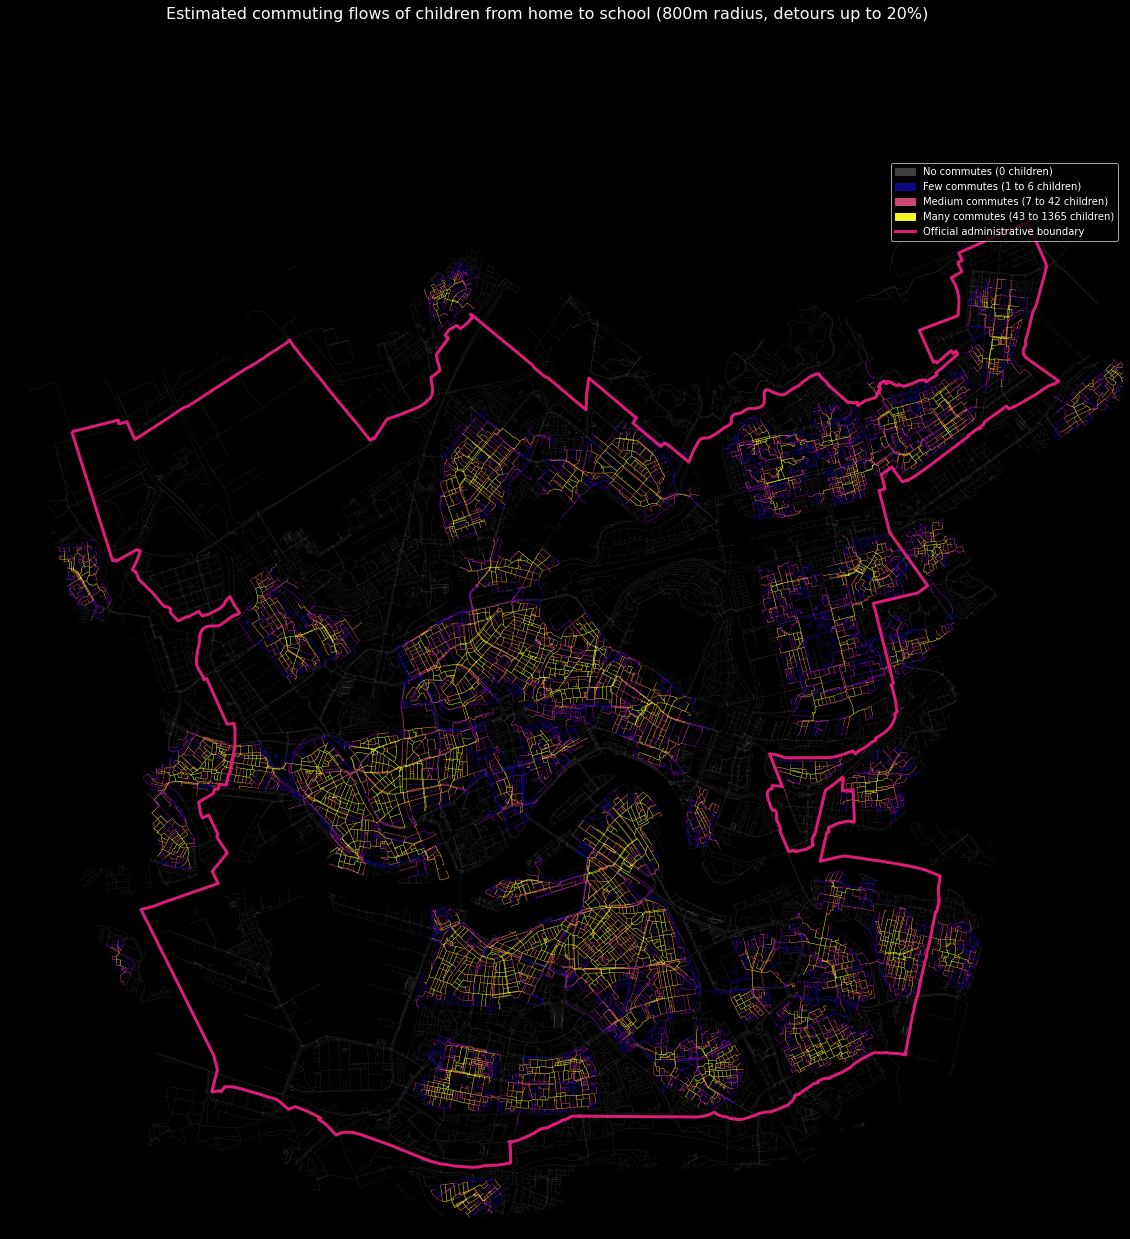

In [28]:
quantiles = betw_cld[betw_cld[col_cld]>0][col_cld].quantile([0, 0.25, 0.5, 0.75, 1])

cmap = plt.cm.get_cmap('plasma')

# create legend
output_legend_handles = [
    mpatches.Patch(color='#404040', label='No commutes (0 children)'),
    mpatches.Patch(color=cmap(0.0), label='Few commutes (1 to {} children)'.format(int(round(quantiles[0.25])))),
    mpatches.Patch(color=cmap(0.5), label='Medium commutes ({} to {} children)'.format(int(round(quantiles[0.25])+1), int(round(quantiles[0.75])))),
    mpatches.Patch(color=cmap(1.0), label='Many commutes ({} to {} children)'.format(int(round(quantiles[0.75])+1), int(round(quantiles[1])))),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')
]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
fig.suptitle('Estimated commuting flows of children from home to school (800m radius, detours up to 20%)', fontsize=16)

betw_cld[betw_cld[col_cld]==0].plot(ax=axs, color='#404040', zorder=1, linewidth=0.2)
betw_cld[betw_cld[col_cld]>0].plot(ax=axs, column=col_cld, cmap=cmap, scheme='quantiles', zorder=2, linewidth=0.5)
place.plot(ax=axs, facecolor='None', edgecolor='#dd1c77', linewidth=3, zorder=4)
axs.legend(handles=output_legend_handles, loc='upper right')

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
plt.axis('off')

plt.show()

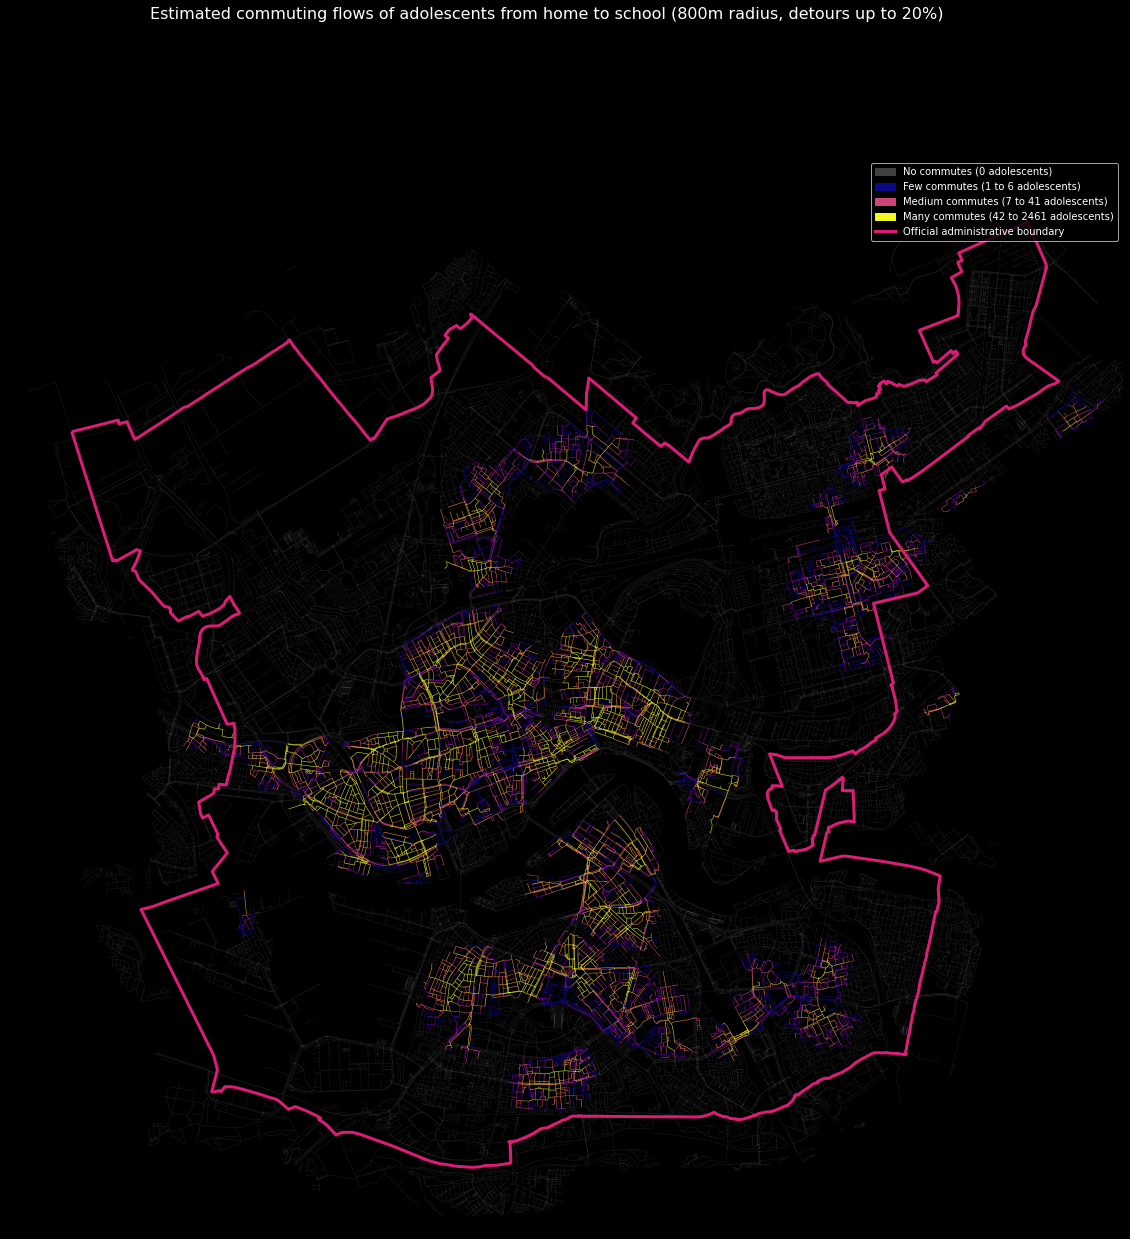

In [29]:
quantiles = betw_adl[betw_adl[col_adl]>0][col_adl].quantile([0, 0.25, 0.5, 0.75, 1])

cmap = plt.cm.get_cmap('plasma')

# create legend
output_legend_handles = [
    mpatches.Patch(color='#404040', label='No commutes (0 adolescents)'),
    mpatches.Patch(color=cmap(0.0), label='Few commutes (1 to {} adolescents)'.format(int(round(quantiles[0.25])))),
    mpatches.Patch(color=cmap(0.5), label='Medium commutes ({} to {} adolescents)'.format(int(round(quantiles[0.25])+1), int(round(quantiles[0.75])))),
    mpatches.Patch(color=cmap(1.0), label='Many commutes ({} to {} adolescents)'.format(int(round(quantiles[0.75])+1), int(round(quantiles[1])))),
    mlines.Line2D([], [], color='#dd1c77', linestyle='-', linewidth=3, label='Official administrative boundary')
]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
fig.suptitle('Estimated commuting flows of adolescents from home to school (800m radius, detours up to 20%)', fontsize=16)

betw_adl[betw_adl[col_adl]==0].plot(ax=axs, color='#404040', zorder=1, linewidth=0.2)
betw_adl[betw_adl[col_adl]>0].plot(ax=axs, column=col_adl, cmap=cmap, scheme='quantiles', zorder=2, linewidth=0.5)
place.plot(ax=axs, facecolor='None', edgecolor='#dd1c77', linewidth=3, zorder=4)
axs.legend(handles=output_legend_handles, loc='upper right')

bbox = place.total_bounds
margin = 1000
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
plt.axis('off')

plt.show()

# Merge results

In [10]:
betw = betw_cld[[id_col, col_cld, 'geometry']].merge(betw_adl[[id_col, col_adl]], how='left', on=id_col)

#  Store output data

In [11]:
output_sub_folder = os.path.join(input_output_folder, sub_folder)

In [12]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [13]:
output_file = os.path.join(output_sub_folder, 'betw_{}_complete.geojson'.format(str(betw_radius)))
betw.to_file(output_file, driver='GeoJSON')